In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
np.set_printoptions(threshold=10000, suppress=True)
warnings.filterwarnings('ignore')
np.random.seed(1)

# Import du dataset

In [67]:
wine1 = pd.read_csv("./winemag-data_first150k.csv", header=0, sep=",")
wine2 = pd.read_csv("./winemag-data-130k-v2.csv",header=0,sep=",")
wine1.drop(['Unnamed: 0'],axis=1,inplace=True)
wine2.drop(['Unnamed: 0','taster_name','taster_twitter_handle','title'],axis=1,inplace=True) #pour avoir les
wine=pd.concat([wine1,wine2],axis=0)
wine.drop(wine.loc[wine['country']=='US-France'].index, axis=0,inplace=True) # supprimer la ligne avec le pays US-France
wine.drop_duplicates(keep='first', inplace=True) # supprimer les doublons
wine.reset_index(drop=True, inplace=True) #reset les indices apres avoir retirer les doublons
len(wine)

170530

In [56]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
data = wine.values

# Statistiques élémentaires

In [68]:
# Combien de critiques ?
len(wine)

170530

In [69]:
# Combien de pays différents ?
len(np.unique(wine['country'].dropna()))

49

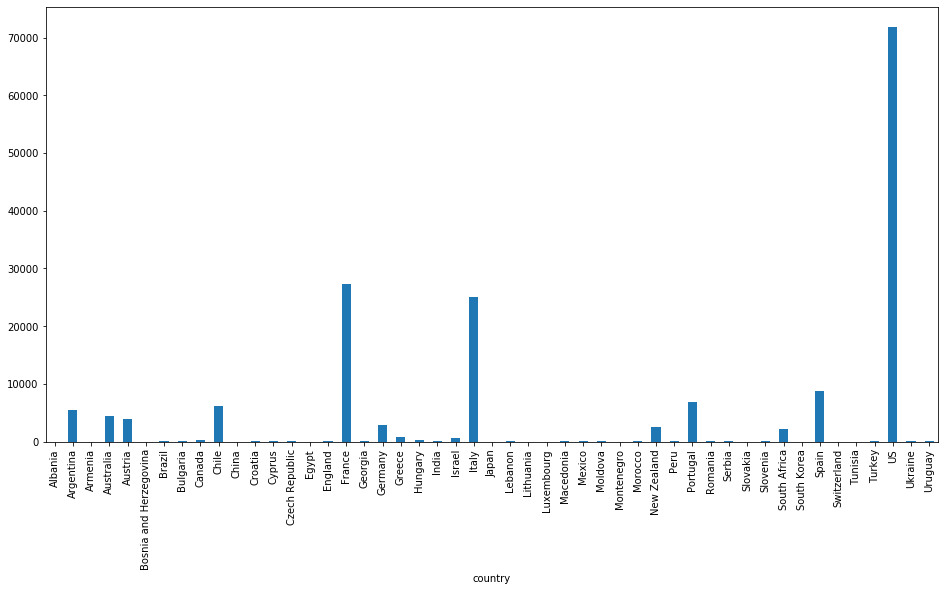

In [72]:
# D'où viennent les vins du dataset ?
wine.groupby('country').count()['points'].plot(kind='bar',figsize=(16,8));

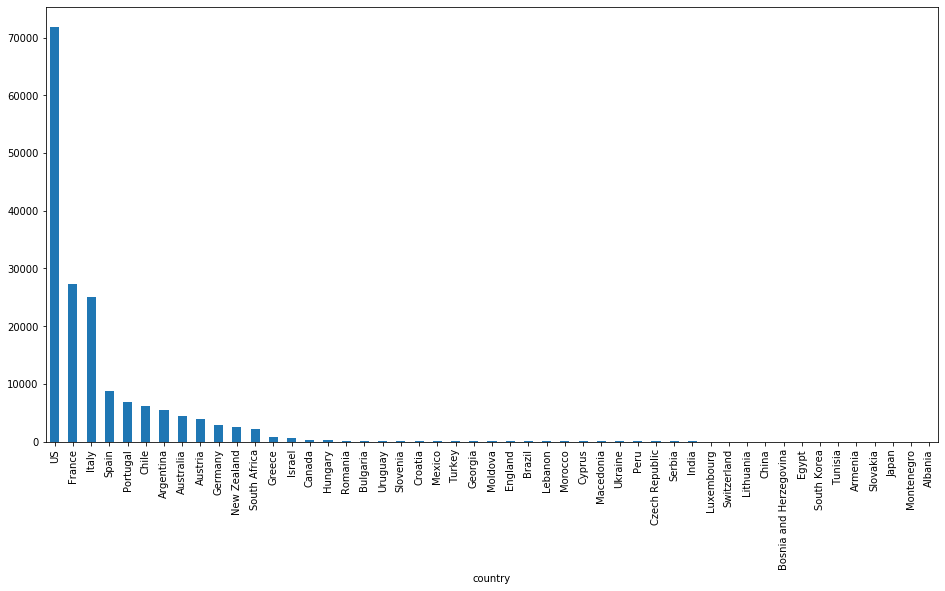

In [73]:
# tri décroissant
wine.groupby('country').count()['points'].sort_values(ascending=False).plot(kind='bar',figsize=(16,8));

In [74]:
# Combien de variétés différentes ?
len(np.unique(wine['variety'].dropna()))

756

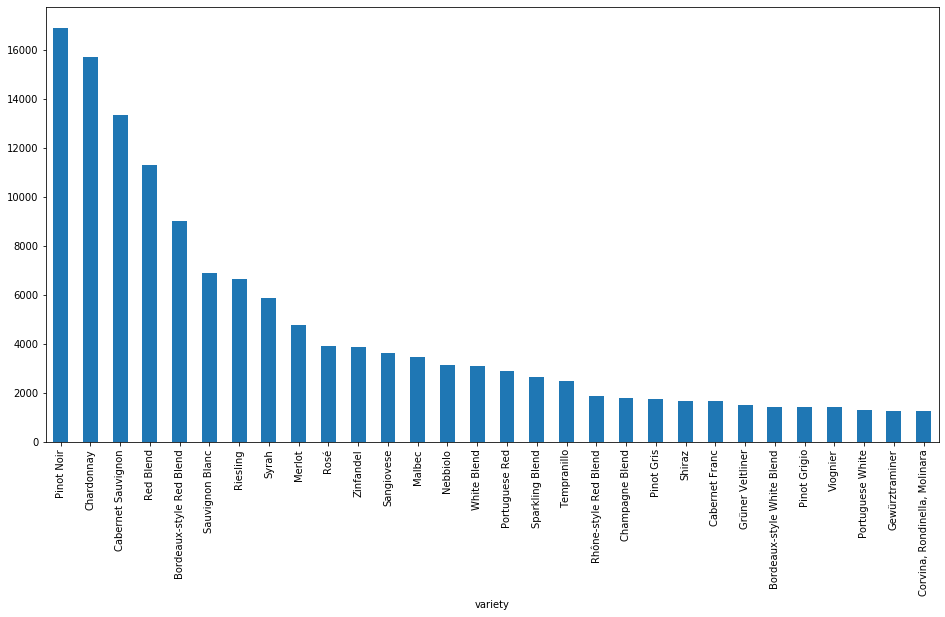

In [76]:
# Comment se répartissent les vins sur les 30 variétés les plus présentes ?
wine.groupby('variety').count()['points'].sort_values(ascending=False).iloc[:30].plot(kind='bar',figsize=(16,8));

In [77]:
from collections import Counter

counter_variety = Counter(wine['variety'])
# les 5 variétés les plus présentes
counter_variety.most_common(5)

[('Pinot Noir', 16894),
 ('Chardonnay', 15712),
 ('Cabernet Sauvignon', 13360),
 ('Red Blend', 11283),
 ('Bordeaux-style Red Blend', 9035)]

# Etude univariée

## qualité

In [78]:
wine['points'].describe().round(2)

count    170530.00
mean         88.24
std           3.15
min          80.00
25%          86.00
50%          88.00
75%          90.00
max         100.00
Name: points, dtype: float64

Toutes les critiques ont une note, comprise entre 80 et 100.

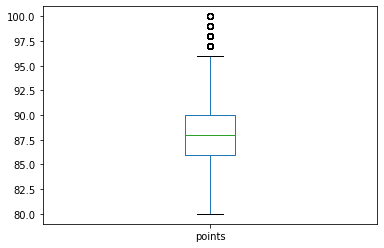

In [79]:
wine['points'].plot(kind='box');

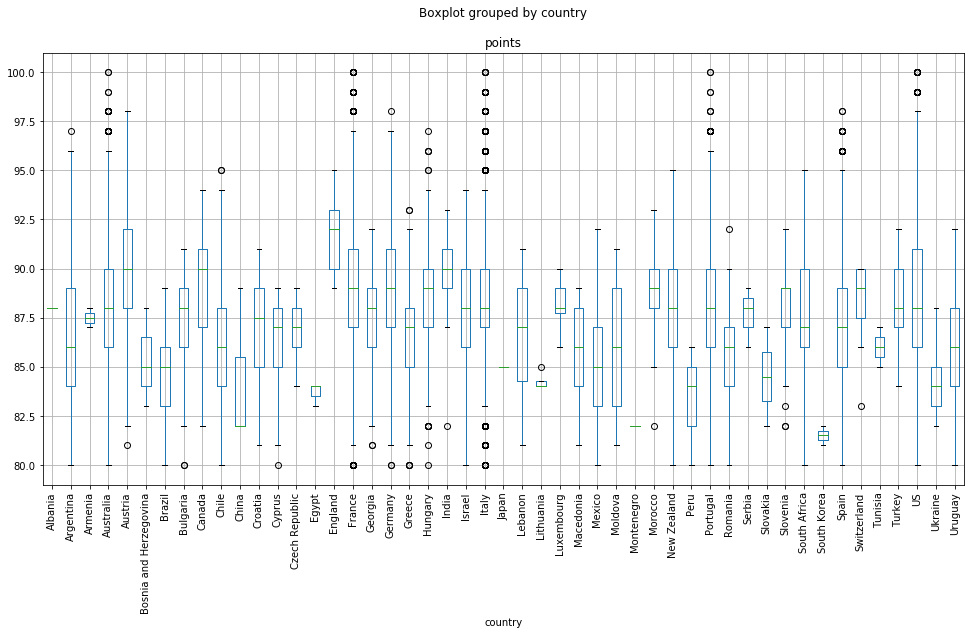

In [80]:
wine.boxplot("points",by='country',rot=90,figsize=(16,8))

## prix

In [81]:
wine['price'].describe().round(2)

count    157689.00
mean         34.66
std          39.84
min           4.00
25%          16.00
50%          25.00
75%          40.00
max        3300.00
Name: price, dtype: float64

Toutes les critiques ne notent pas forcément le prix du vin. Le prix s'étend de 4 à 2300€ avec une moyenne de 33€.

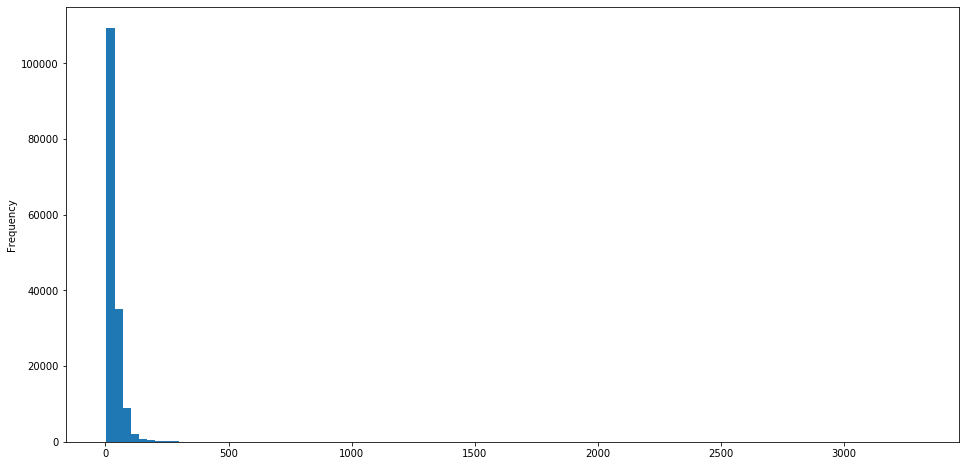

In [82]:
wine['price'].plot(kind='hist', bins=100,figsize=(16,8));

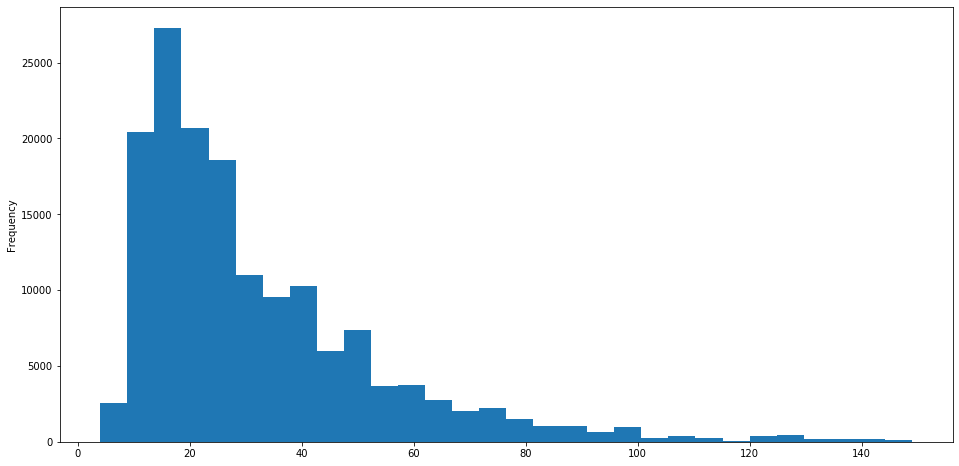

In [83]:
# Zoom sur les prix inférieurs à 150
wine['price'].where(wine['price'] < 150).plot(kind='hist', bins=30,figsize=(16,8));

In [84]:
# étude du prix par pays
wine.groupby('country')['price'].agg([np.mean, np.std, np.median, np.min, np.max]).head()

,mean,std,median,amin,amax
country,,,,,
Albania,20.000000,NaN,20.0,20.0,20.0
Argentina,23.093301,22.474616,15.0,4.0,250.0
Armenia,14.500000,0.707107,14.5,14.0,15.0
Australia,32.726037,43.787960,20.0,5.0,850.0
Austria,31.613657,26.623937,25.0,7.0,1100.0


# Etude bivariée

## quantitative-quantitative

In [85]:
wine[['points','price']].corr('pearson')

,points,price
points,1.000000,0.426825
price,0.426825,1.000000


Il existe une dépendance entre la qualité et le prix du vin.

In [86]:
wine[['points','price']].corr('spearman')

,points,price
points,1.000000,0.606468
price,0.606468,1.000000


Cette dépendance ne semble pas être linéaire puisque le coefficient de Spearman est supérieur à celui de Pearson.

## quantitative-qualitative

In [87]:
# définition du rapport de corrélation

def correlation_ratio(categories, measurements):
    """
    categories : qualitative
    measurements : quantitative
    """
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [88]:
correlation_ratio(wine['country'], wine['points'])

0.05252950007009831

In [89]:
correlation_ratio(wine['variety'], wine['points'])

0.09364833386019773

In [90]:
# il est nécessaire de retirer les données manquantes pour calculer le rapport de corrélation
wine_pricena = wine.dropna(subset=['price']).reset_index(drop=True)
len(wine_pricena)

157689

In [91]:
correlation_ratio(wine_pricena['country'], wine_pricena['price'])

0.02273141615484447

In [92]:
correlation_ratio(wine_pricena['variety'], wine_pricena['price'])

0.08539590851267864